✅ Total images: 5712
class
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
📊 Train: 3883, Val: 686, Test: 1143
Found 3883 validated image filenames belonging to 4 classes.
Found 686 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 95s 560ms/step - accuracy: 0.3500 - loss: 1.2721 - val_accuracy: 0.6880 - val_loss: 0.8296
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 397ms/step - accuracy: 0.6290 - loss: 0.8786 - val_accuracy: 0.7187 - val_loss: 0.6541
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.6919 - loss: 0.7284 - val_accuracy: 0.6691 - val_loss: 0.8526
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 405ms/step - accuracy: 0.7087 - loss: 0.6736 - val_accuracy: 0.7609 - val_loss: 0.5800
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 48s 393ms/step - accuracy: 0.7260 - loss: 0.6363 - val_accuracy: 0.7580 - val_loss: 0.6180
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 398ms/step - accuracy: 0.7791 - loss: 0.5679 - val_accuracy: 0.7930 - val_loss: 0.5091
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 381ms/step - accuracy: 0.7868 - loss: 0.5347 - val_accuracy: 0.7828 - val_loss: 0.5547
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 406ms/step - accuracy: 0.8078 - loss: 0

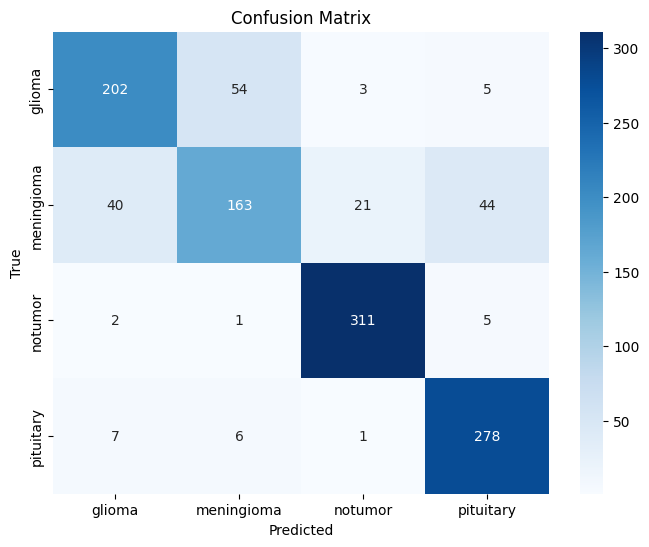

📊 Manual Accuracy: 83.46%


In [26]:
# ✅ Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns

# ======================
# ✅ Step 2: Paths & Parameters
DATASET_PATH = "/kaggle/input/brain-tumar-mri-datset-kaggle-7000-images/Training"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# ======================
# ✅ Step 3: Load image paths and labels
image_paths, labels = [], []
for class_dir in sorted(os.listdir(DATASET_PATH)):
    class_path = os.path.join(DATASET_PATH, class_dir)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))
                labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images: {len(df)}")
print(df['class'].value_counts())

# ======================
# ✅ Step 4: Split into train, val, test
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ======================
# ✅ Step 5: Create ImageDataGenerators (rescaling only)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE
)

val_flow = val_test_gen.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE
)

test_flow = val_test_gen.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)

# ======================
# ✅ Step 6: Build VGG16 model from scratch
num_classes = len(train_flow.class_indices)

base_model = VGG16(weights=None, include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ======================
# ✅ Step 7: Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ======================
# ✅ Step 8: Train model
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_vgg16_model.keras", save_best_only=True)
]

history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ======================
# ✅ Step 9: Evaluate model
loss, acc = model.evaluate(test_flow)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# ======================
# ✅ Step 10: Predictions
y_true = test_flow.classes
y_pred = np.argmax(model.predict(test_flow), axis=1)
labels = list(test_flow.class_indices.keys())

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ======================
# ✅ Step 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ======================
# ✅ Step 12: Manual Accuracy Calculation
correct_preds = np.sum(y_pred == y_true)
total_preds = len(y_true)
manual_acc = correct_preds / total_preds
print(f"📊 Manual Accuracy: {manual_acc*100:.2f}%")
